<a href="https://colab.research.google.com/github/fajrunwm/ctscan/blob/main/Lung_Cancer_U_Net_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lung CT Slice Segmentation (Binary)
with 2D U-Net (TensorFlow/Keras)

In [1]:
# Assumes df has columns: "hu_array_old" (CT HU image), "mask" (binary/label mask)

import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1) Load Data

In [3]:
# df = pd.read_pickle("/content/drive/MyDrive/lung cancer/Lung cancer segmentation dataset with Lung-RADS class/lung_cancer_train.pkl")
df = pd.read_pickle("/content/drive/MyDrive/15. Medical Disease Prediction/Lung cancer segmentation dataset with Lung-RADS class/lung_cancer_train.pkl")
# df = pd.read_pickle(r"D:\2. WAHIDIL\Careers\Devdat.ai\15. Medical Disease Prediction\Lung cancer segmentation dataset with Lung-RADS class\lung_cancer_train.pkl")

print(df.columns)
print("N samples:", len(df))


Index(['label1', 'mask', 'hu_array', 'hu_array_old'], dtype='object')
N samples: 708


## 2) Quick sanity check

Sample shapes: (512, 512) (512, 512) mask uniques: [0 1]


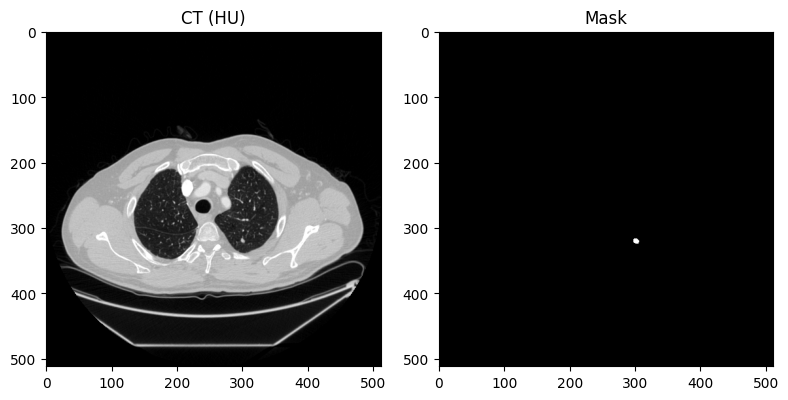

In [9]:
row = df.sample(n=1).iloc[0]
img0 = np.array(row["hu_array_old"])
msk0 = np.array(row["mask"])
print("Sample shapes:", img0.shape, msk0.shape, "mask uniques:", np.unique(msk0)[:10])

palette = "grey"

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img0, cmap=palette, vmin=-1000, vmax=400); plt.title("CT (HU)")
plt.subplot(1,2,2); plt.imshow(msk0, cmap=palette); plt.title("Mask")
plt.tight_layout(); plt.show()

## 3) Preprocess

In [10]:
IMG_SIZE = 256
HU_MIN, HU_MAX = -1000, 400

def preprocess(img, mask, size=IMG_SIZE, hu_min=HU_MIN, hu_max=HU_MAX):
    img = np.array(img)
    mask = np.array(mask)

    # HU window + normalize to 0..1
    img = np.clip(img, hu_min, hu_max).astype(np.float32)
    img = (img - hu_min) / float(hu_max - hu_min)  # 0..1

    # Resize
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (size, size), interpolation=cv2.INTER_NEAREST)

    # Ensure binary mask (0/1)
    mask = (mask > 0).astype(np.float32)

    # Add channel dim: (H,W,1)
    img = img[..., None]
    mask = mask[..., None]
    return img, mask

# Build arrays
X = np.zeros((len(df), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
Y = np.zeros((len(df), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

for i in range(len(df)):
    img = df.iloc[i]["hu_array_old"]
    mask = df.iloc[i]["mask"]
    X[i], Y[i] = preprocess(img, mask)

print("X, Y:", X.shape, Y.shape)
print("Y unique:", np.unique(Y))

X, Y: (708, 256, 256, 1) (708, 256, 256, 1)
Y unique: [0. 1.]


## 4) Train/Val split

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [12]:
import tensorflow as tf

# List available GPUs
print("GPUs available:", tf.config.list_physical_devices('GPU'))

# Check which device TensorFlow is using
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6320941472818258778
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14426112000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4117112731513150652
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## 5) Build U-Net Model

In [13]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x) # Added Dropout
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x) # Added Dropout
    return x

def build_unet(input_shape=(256,256,1), base_filters=64): # Changed base_filters default from 32 to 64
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, base_filters)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, base_filters*2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, base_filters*4)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, base_filters*8)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, base_filters*16)

    # Decoder
    u1 = layers.UpSampling2D()(bn)
    u1 = layers.Concatenate()([u1, c4])
    c5 = conv_block(u1, base_filters*8)

    u2 = layers.UpSampling2D()(c5)
    u2 = layers.Concatenate()([u2, c3])
    c6 = conv_block(u2, base_filters*4)

    u3 = layers.UpSampling2D()(c6)
    u3 = layers.Concatenate()([u3, c2])
    c7 = conv_block(u3, base_filters*2)

    u4 = layers.UpSampling2D()(c7)
    u4 = layers.Concatenate()([u4, c1])
    c8 = conv_block(u4, base_filters)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c8)
    return Model(inputs, outputs)

## 6) Loss + metrics

In [14]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1.0 - (2.0 * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

## 7) Train

In [15]:
model = build_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1), base_filters=64) # Changed base_filters form 32 to 64
model.compile(optimizer=tf.keras.optimizers.Adam(5e-5), # Changed learning rate from 5e-4 to 5e-5
              loss=bce_dice_loss,
              metrics=[iou_metric])

model.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("unet_ct_best.keras", monitor="val_loss", save_best_only=True),
]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ dropout_1[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128, 128,  │          0 │ re_lu_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ dropout_3[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 64, 64,    │          0 │ conv2d_4[0][0]  

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    batch_size=16, # Changed batch_size form 8 to 16
    callbacks=callbacks
)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 277s 5s/step - iou_metric: 5.6209e-04 - loss: 1.3262 - val_iou_metric: 6.0877e-04 - val_loss: 1.1746
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - iou_metric: 8.6926e-04 - loss: 1.0292 - val_iou_metric: 0.0073 - val_loss: 1.0577
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - iou_metric: 0.0122 - loss: 0.9988 - val_iou_metric: 0.0076 - val_loss: 1.0745
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - iou_metric: 0.0486 - loss: 0.9304 - val_iou_metric: 0.0115 - val_loss: 1.0290
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - iou_metric: 0.1164 - loss: 0.8231 - val_iou_metric: 0.0183 - val_loss: 0.9937
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - iou_metric: 0.1849 - loss: 0.7196 - val_iou_metric: 0.0593 - val_loss: 0.9082
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - iou_metric: 0.3306 - loss: 0.5368 - val_iou_metric: 0.0665 - val_loss: 0.8946
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - iou_metric: 0.4177 - loss

## 8) Curves

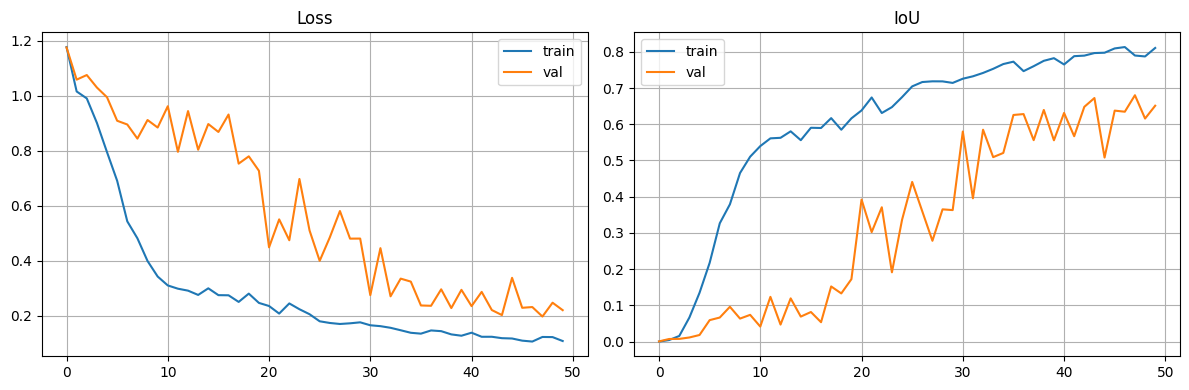

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss"); plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["iou_metric"], label="train")
plt.plot(history.history["val_iou_metric"], label="val")
plt.title("IoU"); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()


## 9) Model Saving

In [18]:
import datetime

# Create a timestamp for the model filename
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_save_path = f"/content/drive/MyDrive/15. Medical Disease Prediction/model/model_{current_time}"

# Ensure the directory exists
import os
output_dir = os.path.dirname(model_save_path)
os.makedirs(output_dir, exist_ok=True)

# Save the model
model.save(f"{model_save_path}.keras")
print(f"Model saved to: {model_save_path}.keras")

Model saved to: /content/drive/MyDrive/15. Medical Disease Prediction/model/model_20260225-052031.keras


## 10) Visualise predictions

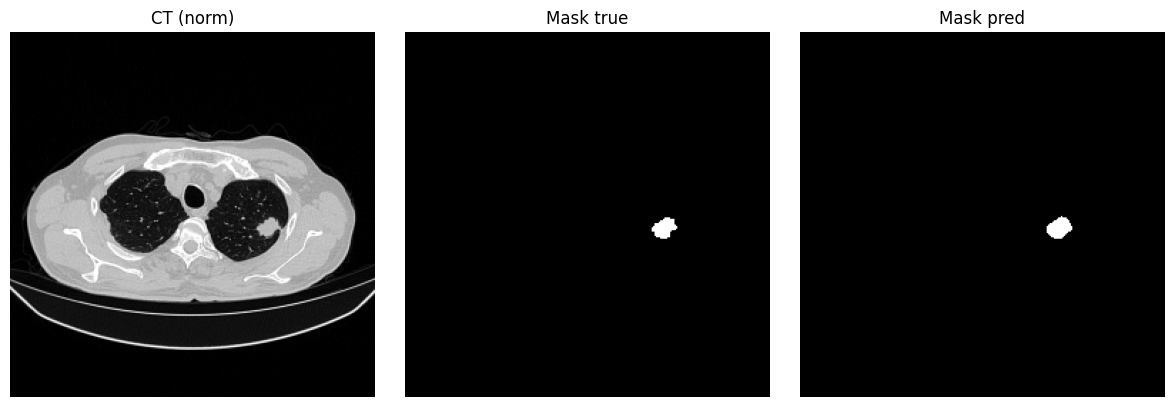

 Unique values of mask pred:
[0. 1.]


In [21]:
# palette = "grey"

def show_prediction(idx):
    x = X_val[idx:idx+1]
    y_true = Y_val[idx].squeeze()
    y_pred = model.predict(x, verbose=0)[0].squeeze()
    y_bin = (y_pred > 0.5).astype(np.float32)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(x[0].squeeze(), cmap=palette); plt.title("CT (norm)"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(y_true, cmap=palette); plt.title("Mask true"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(y_bin, cmap=palette); plt.title("Mask pred"); plt.axis("off")
    plt.tight_layout(); plt.show()

    print(" Unique values of mask pred:")
    print(np.unique(y_bin))

# Randomize index for visualization
random_idx = np.random.randint(0, len(X_val))
show_prediction(random_idx)